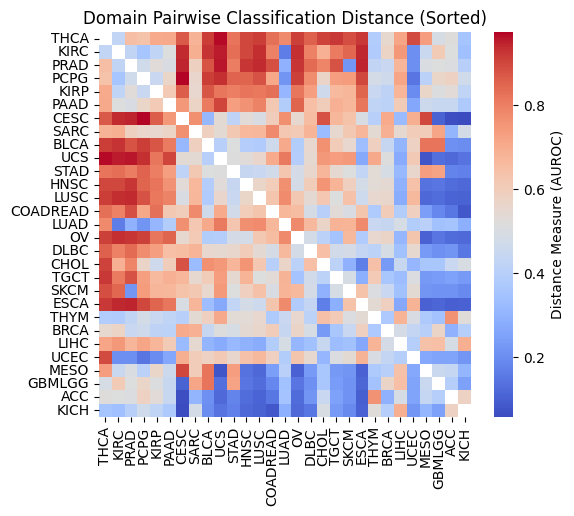

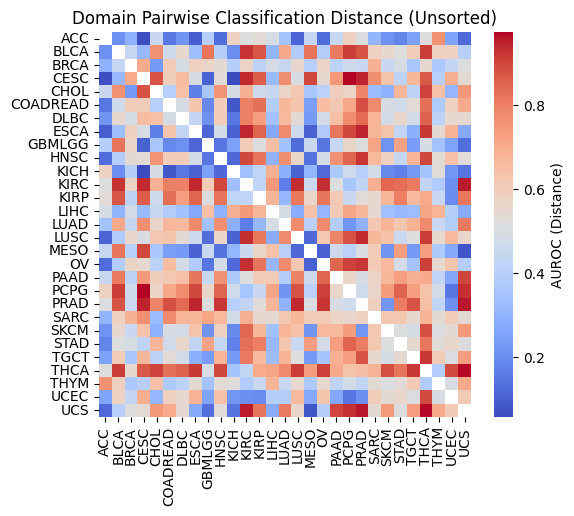

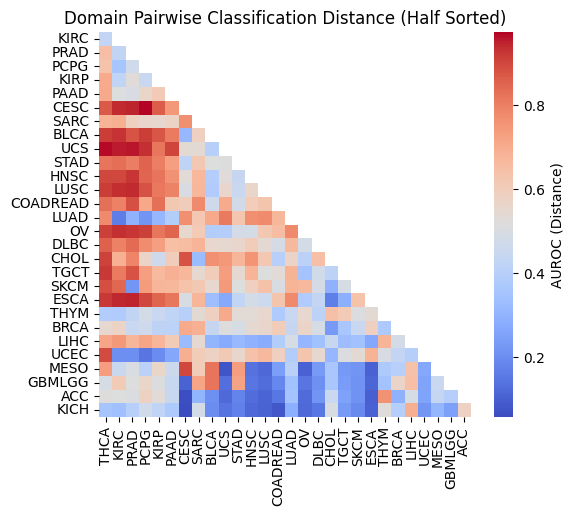

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Define paths
save_root = 'results_final/landscape/domain_classification_one-vs-one/'
pkl_path = f'{save_root}/bootstrap_auc_data.pkl'

# Load previously saved AUC data
with open(pkl_path, 'rb') as handle:
    aucs_dict = pickle.load(handle)

# Get the domains from the keys in aucs_dict
domain_pairs = list(aucs_dict.keys())
domains = sorted(set([pair.split('_vs_')[0] for pair in domain_pairs] + [pair.split('_vs_')[1] for pair in domain_pairs]))

# Prepare the AUC matrix for the heatmap
domain_aucs = {domain: [] for domain in domains}
for pair in domain_pairs:
    domain1, domain2 = pair.split('_vs_')
    if len(aucs_dict[pair]) > 0:
        mean_auc = np.mean(aucs_dict[pair])
        domain_aucs[domain1].append((domain2, mean_auc))
        domain_aucs[domain2].append((domain1, mean_auc))

auc_matrix = np.zeros((len(domains), len(domains)))
for i, domain1 in enumerate(domains):
    for j, domain2 in enumerate(domains):
        if domain1 == domain2:
            auc_matrix[i, j] = 0
        else:
            auc_matrix[i, j] = np.mean([auc for d, auc in domain_aucs[domain1] if d == domain2])

# Convert to DataFrame for better handling and visualization
auc_matrix_df = pd.DataFrame(auc_matrix, columns=domains, index=domains)

############### PLOTTING #########
# Calculate the average value for each row
row_means = np.mean(auc_matrix, axis=1)

# Get the sorted indices of the rows based on the average values in descending order
sorted_indices = np.argsort(-row_means)

# Reorder the rows and columns of the auc_matrix based on the sorted indices
sorted_auc_matrix = auc_matrix[sorted_indices, :][:, sorted_indices]

# Set diagonal values to NaN for better visualization
for i in range(sorted_auc_matrix.shape[0]):
    sorted_auc_matrix[i, i] = np.nan

# Reorder the domain labels accordingly
sorted_domains = [domains[i] for i in sorted_indices]

# Plot the sorted AUROC matrix
fig_size = (6,5)
plt.figure(figsize=fig_size)
sns.heatmap(sorted_auc_matrix, xticklabels=sorted_domains, yticklabels=sorted_domains, cmap='coolwarm', cbar_kws={'label': 'Distance Measure (AUROC)'})
plt.title('Domain Pairwise Classification Distance (Sorted)')
plt.savefig(f"{save_root}/Pairwise_Classification_SORTED_COMPLETE.png", bbox_inches='tight', dpi=600)
# plt.savefig(f"{save_root}/Pairwise_Classification_SORTED_COMPLETE.pdf", bbox_inches='tight', dpi=600)

# Plot the unsorted AUROC matrix
plt.figure(figsize=fig_size)
for i in range(auc_matrix.shape[0]):
    for j in range(auc_matrix.shape[1]):
        if i == j:
            auc_matrix[i, j] = np.nan
sns.heatmap(auc_matrix, xticklabels=domains, yticklabels=domains, cmap='coolwarm', cbar_kws={'label': 'AUROC (Distance)'})
plt.title('Domain Pairwise Classification Distance (Unsorted)')
plt.savefig(f"{save_root}/Pairwise_Classification_NOTSORTED_COMPLETE.png", bbox_inches='tight', dpi=600)
# plt.savefig(f"{save_root}/Pairwise_Classification_NOTSORTED_COMPLETE.pdf", bbox_inches='tight', dpi=600)

# Plot the half-sorted AUROC matrix
plt.figure(figsize=fig_size)
half_sorted_auc_matrix = np.copy(sorted_auc_matrix)
for i in range(half_sorted_auc_matrix.shape[0]):
    for j in range(half_sorted_auc_matrix.shape[1]):
        if i < j:
            half_sorted_auc_matrix[i, j] = np.nan
sns.heatmap(half_sorted_auc_matrix[1:, :-1], xticklabels=sorted_domains[:-1], yticklabels=sorted_domains[1:], cmap='coolwarm', cbar_kws={'label': 'AUROC (Distance)'})
plt.title('Domain Pairwise Classification Distance (Half Sorted)')
plt.savefig(f"{save_root}/Pairwise_Classification_SORTED_HALF.png", bbox_inches='tight', dpi=600)
# plt.savefig(f"{save_root}/Pairwise_Classification_SORTED_HALF.pdf", bbox_inches='tight', dpi=600)


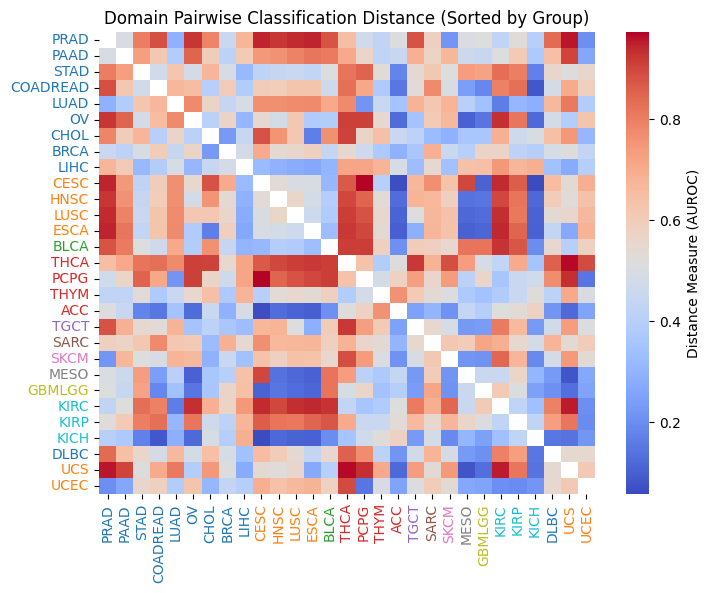

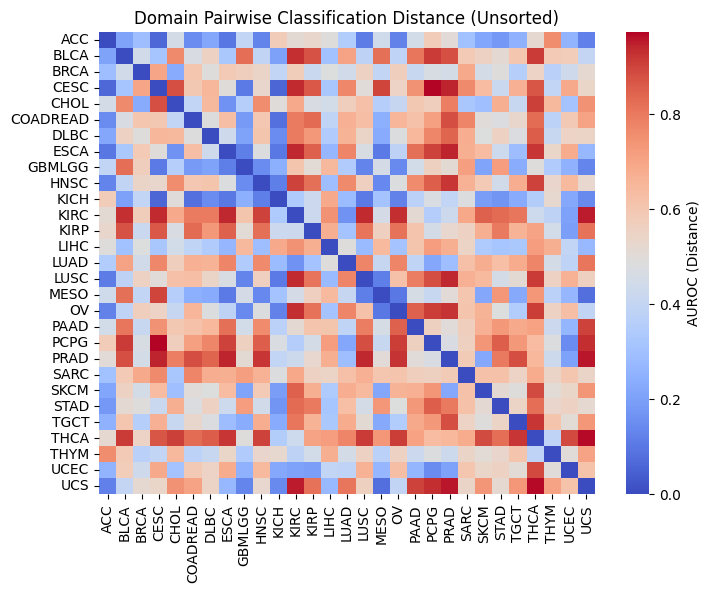

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.colors import to_rgba
from matplotlib import patheffects

# Define paths
save_root = 'results_final/landscape/domain_classification_one-vs-one/'
pkl_path = f'{save_root}/bootstrap_auc_data.pkl'

# Load previously saved AUC data
with open(pkl_path, 'rb') as handle:
    aucs_dict = pickle.load(handle)

# Define the groups
# domain_groups = {
#     'Adenocarcinomas': ['BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV'],
#     'Squamous Cell Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA'],
#     'Urothelial Carcinomas': ['BLCA'],
#     'Endocrine Cancers': ['THCA', 'THYM', 'ACC', 'PCPG'],
#     'Germ Cell Tumors': ['TGCT'],
#     'Soft Tissue and Bone Cancers': ['SARC'],
#     'Skin and Related Cancers': ['SKCM'],
#     'Mesothelium derived Cancers': ['MESO'],
#     'Hepatic Cancers': ['LIHC'],
#     'Glioma': ['GBMLGG']
# }

# domain_groups = {
#     'Central Nervous System (CNS)': ['GBMLGG'],
#     'Head and Neck': ['HNSC', 'THCA', 'THYM'],
#     'Thoracic (Chest)': ['LUAD', 'LUSC', 'MESO'],
#     'Gastrointestinal Tract': ['ESCA', 'STAD', 'COADREAD', 'PAAD', 'CHOL', 'LIHC'],
#     'Genitourinary System': ['BLCA', 'KICH', 'KIRC', 'KIRP', 'PCPG', 'PRAD', 'TGCT', 'UCEC', 'UCS', 'CESC', 'OV'],
#     'Breast': ['BRCA'],
#     'Skin': ['SKCM'],
#     'Soft Tissue': ['SARC'],
#     'Adrenal Gland': ['ACC'],
#     'Lymphoid': ['DLBC']
# }

domain_groups = { 
    'Adenocarcinomas': ['BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV', 'LIHC'],  # Added LIHC, ESCA
    'Squamous Cell Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA'],  # ESCA remains here as it has a squamous cell subtype
    'Urothelial Carcinomas': ['BLCA'],
    'Endocrine Cancers': ['THCA', 'THYM', 'ACC', 'PCPG'],
    'Germ Cell Tumors': ['TGCT'],
    'Soft Tissue and Bone Cancers': ['SARC'],
    'Skin and Related Cancers': ['SKCM'],
    'Mesothelium derived Cancers': ['MESO'],
    'Glioma': ['GBMLGG'],  # Combined GBM and LGG under "Glioma"
    'Kidney Cancers': ['KICH', 'KIRC', 'KIRP'],  # New group for kidney cancers
    'Lymphoid Neoplasms': ['DLBC'],  # New group for lymphoid cancers
    'Uterine Cancers': ['UCEC', 'UCS'],  # New group for uterine cancers
}

# Use the tab10 colormap for group colors
tab10_cmap = plt.get_cmap("tab10")
group_colors_list = tab10_cmap.colors  # Extract the colors from tab10
group_colors = {group: group_colors_list[i % len(group_colors_list)] for i, group in enumerate(domain_groups)}

# Get the domains from the keys in aucs_dict
domain_pairs = list(aucs_dict.keys())
domains = sorted(set([pair.split('_vs_')[0] for pair in domain_pairs] + [pair.split('_vs_')[1] for pair in domain_pairs]))

# Create a mapping from domain to group
domain_to_group = {}
for group, group_domains in domain_groups.items():
    for domain in group_domains:
        domain_to_group[domain] = group

# Prepare the AUC matrix for the heatmap
domain_aucs = {domain: [] for domain in domains}
for pair in domain_pairs:
    domain1, domain2 = pair.split('_vs_')
    if len(aucs_dict[pair]) > 0:
        mean_auc = np.mean(aucs_dict[pair])
        domain_aucs[domain1].append((domain2, mean_auc))
        domain_aucs[domain2].append((domain1, mean_auc))

auc_matrix = np.zeros((len(domains), len(domains)))
for i, domain1 in enumerate(domains):
    for j, domain2 in enumerate(domains):
        if domain1 == domain2:
            auc_matrix[i, j] = 0
        else:
            auc_matrix[i, j] = np.mean([auc for d, auc in domain_aucs[domain1] if d == domain2])

# Convert to DataFrame for better handling and visualization
auc_matrix_df = pd.DataFrame(auc_matrix, columns=domains, index=domains)

############### GROUPING AND SORTING #########
# Sort by group first and then by average AUROC
sorted_domains = []
for group in domain_groups:
    group_domains = domain_groups[group]
    group_aucs = [(domain, np.mean(auc_matrix_df.loc[domain])) for domain in group_domains if domain in auc_matrix_df.index]
    group_sorted = [domain for domain, _ in sorted(group_aucs, key=lambda x: -x[1])]
    sorted_domains.extend(group_sorted)

# Reorder the auc_matrix based on the sorted_domains
sorted_auc_matrix = auc_matrix_df.loc[sorted_domains, sorted_domains].values

# Set diagonal values to NaN for better visualization
for i in range(sorted_auc_matrix.shape[0]):
    sorted_auc_matrix[i, i] = np.nan

# Color the labels based on their group
domain_colors = [group_colors[domain_to_group[domain]] for domain in sorted_domains]

# Custom colormap for seaborn
custom_cmap = sns.color_palette("coolwarm", as_cmap=True)

############### PLOTTING #########

# Define the stroke effect for text (black outline around text)
text_effect = [patheffects.withStroke(linewidth=1, foreground='black')]

# Plot the sorted AUROC matrix with group-based label colors
plt.figure(figsize=(8, 6))
sns.heatmap(sorted_auc_matrix, xticklabels=sorted_domains, yticklabels=sorted_domains, cmap=custom_cmap, cbar_kws={'label': 'Distance Measure (AUROC)'}, annot=False)

# Add color to domain labels and apply stroke effect to make the labels more readable
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_color(group_colors[domain_to_group[label.get_text()]])
    # label.set_path_effects(text_effect)  # Apply black stroke

for label in ax.get_yticklabels():
    label.set_color(group_colors[domain_to_group[label.get_text()]])
    # label.set_path_effects(text_effect)  # Apply black stroke

plt.title('Domain Pairwise Classification Distance (Sorted by Group)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the plot
# plt.savefig(f"{save_root}/Pairwise_Classification_GROUPED_SORTED_withStroke.png", bbox_inches='tight', dpi=600)
# plt.savefig(f"{save_root}/Pairwise_Classification_GROUPED_SORTED_withStroke.pdf", bbox_inches='tight', dpi=600)
plt.show()

# Plot the unsorted AUROC matrix for comparison
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, xticklabels=domains, yticklabels=domains, cmap=custom_cmap, cbar_kws={'label': 'AUROC (Distance)'})
plt.title('Domain Pairwise Classification Distance (Unsorted)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
# plt.savefig(f"{save_root}/Pairwise_Classification_NOTSORTED_withStroke.png", bbox_inches='tight', dpi=600)
# plt.savefig(f"{save_root}/Pairwise_Classification_NOTSORTED_withStroke.pdf", bbox_inches='tight', dpi=600)
plt.show()


/tmp/ipykernel_2223132/2181936969.py:87: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(auc_matrix_df, method='average')


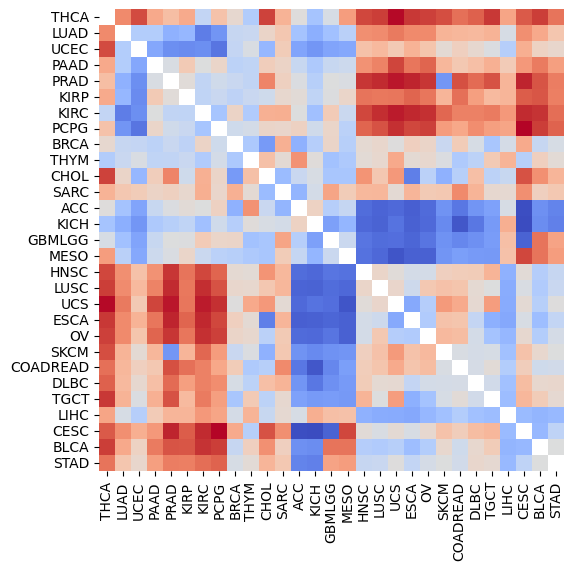

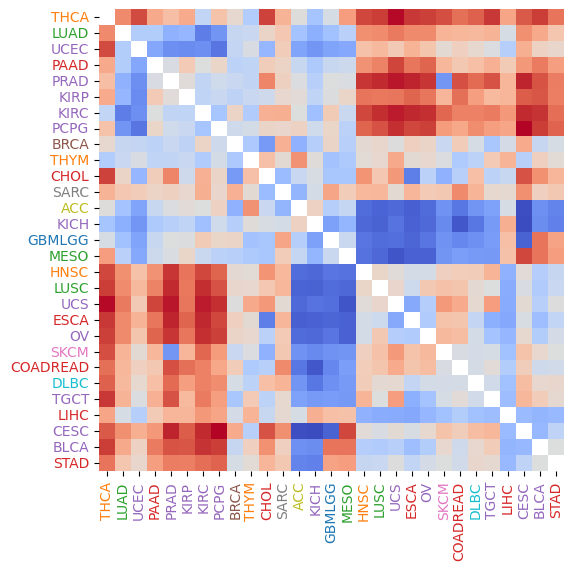

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.colors import to_rgba
from matplotlib import patheffects
from scipy.cluster.hierarchy import linkage, leaves_list

# Define paths
save_root = 'results_final/landscape/domain_classification_one-vs-one/'
pkl_path = f'{save_root}/bootstrap_auc_data.pkl'

# Load previously saved AUC data
with open(pkl_path, 'rb') as handle:
    aucs_dict = pickle.load(handle)

# Define the groups
# domain_groups = { 
#     # 'Adenocarcinomas': ['BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV', 'LIHC'],
#     # 'Squamous Cell Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA'],
#     # 'Urothelial Carcinomas': ['BLCA'],
#     # 'Uterine Cancers': ['UCEC', 'UCS'],
#     'Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA', 'BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV', 'LIHC', 'BLCA', 'UCEC', 'UCS'],
#     'Endocrine Cancers': ['THCA', 'THYM', 'ACC', 'PCPG'],
#     'Germ Cell Tumors': ['TGCT'],
#     'Soft Tissue and Bone Cancers': ['SARC'],
#     'Skin and Related Cancers': ['SKCM'],
#     'Mesothelium derived Cancers': ['MESO'],
#     'Glioma': ['GBMLGG'],
#     'Kidney Cancers': ['KICH', 'KIRC', 'KIRP'],
#     'Lymphoid Neoplasms': ['DLBC'],
    
# }

domain_groups = {
    'Central Nervous System (CNS)': ['GBMLGG'],
    'Head and Neck': ['HNSC', 'THCA', 'THYM'],
    'Thoracic (Chest)': ['LUAD', 'LUSC', 'MESO'],
    'Gastrointestinal Tract': ['ESCA', 'STAD', 'COADREAD', 'PAAD', 'CHOL', 'LIHC'],
    'Genitourinary System': ['BLCA', 'KICH', 'KIRC', 'KIRP', 'PCPG', 'PRAD', 'TGCT', 'UCEC', 'UCS', 'CESC', 'OV'],
    'Breast': ['BRCA'],
    'Skin': ['SKCM'],
    'Soft Tissue': ['SARC'],
    'Adrenal Gland': ['ACC'],
    'Lymphoid Neoplasms': ['DLBC']
}

# Use the tab10 colormap for group colors
tab10_cmap = plt.get_cmap("tab10")
group_colors_list = tab10_cmap.colors  # Extract the colors from tab10
group_colors = {group: group_colors_list[i % len(group_colors_list)] for i, group in enumerate(domain_groups)}

# Get the domains from the keys in aucs_dict
domain_pairs = list(aucs_dict.keys())
domains = sorted(set([pair.split('_vs_')[0] for pair in domain_pairs] + [pair.split('_vs_')[1] for pair in domain_pairs]))

# Create a mapping from domain to group
domain_to_group = {}
for group, group_domains in domain_groups.items():
    for domain in group_domains:
        domain_to_group[domain] = group

# Prepare the AUC matrix for the heatmap
domain_aucs = {domain: [] for domain in domains}
for pair in domain_pairs:
    domain1, domain2 = pair.split('_vs_')
    if len(aucs_dict[pair]) > 0:
        mean_auc = np.mean(aucs_dict[pair])
        domain_aucs[domain1].append((domain2, mean_auc))
        domain_aucs[domain2].append((domain1, mean_auc))

auc_matrix = np.zeros((len(domains), len(domains)))
for i, domain1 in enumerate(domains):
    for j, domain2 in enumerate(domains):
        if domain1 == domain2:
            auc_matrix[i, j] = 0
        else:
            auc_matrix[i, j] = np.mean([auc for d, auc in domain_aucs[domain1] if d == domain2])

# Convert to DataFrame for better handling and visualization
auc_matrix_df = pd.DataFrame(auc_matrix, columns=domains, index=domains)

############### CLUSTERING #########
# Perform hierarchical clustering using linkage method
linkage_matrix = linkage(auc_matrix_df, method='average')

# Reorder based on hierarchical clustering
cluster_order = leaves_list(linkage_matrix)
clustered_domains = [domains[i] for i in cluster_order]

# Reorder the auc_matrix based on clustering
clustered_auc_matrix = auc_matrix_df.values[cluster_order, :][:, cluster_order]

# Set diagonal values to NaN for better visualization
for i in range(clustered_auc_matrix.shape[0]):
    clustered_auc_matrix[i, i] = np.nan

# Color the labels based on their group
domain_colors = [group_colors[domain_to_group[domain]] for domain in clustered_domains]

# Custom colormap for seaborn
custom_cmap = sns.color_palette("coolwarm", as_cmap=True)

############### PLOTTING #########
# Define the stroke effect for text (black outline around text)
text_effect = [patheffects.withStroke(linewidth=1, foreground='black')]

# Plot the clustered AUROC matrix with group-based label colors
plt.figure(figsize=(6, 6))
sns.heatmap(clustered_auc_matrix, xticklabels=clustered_domains, yticklabels=clustered_domains, cmap=custom_cmap,
            cbar=False,
            cbar_kws={'label': 'Distance Measure (AUROC)'}, annot=False)

# Save the plot
plt.savefig(f"{save_root}/Pairwise_Classification_CLUSTERED.png", bbox_inches='tight', dpi=600, pad_inches=0.01)
plt.show()

# Plot the clustered AUROC matrix with group-based label colors
plt.figure(figsize=(6, 6))
sns.heatmap(clustered_auc_matrix, xticklabels=clustered_domains, yticklabels=clustered_domains, cmap=custom_cmap,
            cbar=False,
            cbar_kws={'label': 'Distance Measure (AUROC)'}, annot=False)

# Add color to domain labels and apply stroke effect to make the labels more readable
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_color(group_colors[domain_to_group[label.get_text()]])
    # label.set_path_effects(text_effect)  # Apply black stroke

for label in ax.get_yticklabels():
    label.set_color(group_colors[domain_to_group[label.get_text()]])
    # label.set_path_effects(text_effect)  # Apply black stroke

# plt.title('Domain Pairwise Classification Distance (Clustered)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the plot
plt.savefig(f"{save_root}/Pairwise_Classification_CLUSTERED_citeGroup.png", bbox_inches='tight', dpi=600, pad_inches=0.01)
plt.show()


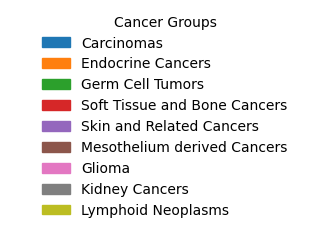

In [30]:
import matplotlib.patches as mpatches

domain_groups = { 
    # 'Adenocarcinomas': ['BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV', 'LIHC'],
    # 'Squamous Cell Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA'],
    # 'Urothelial Carcinomas': ['BLCA'],
    # 'Uterine Cancers': ['UCEC', 'UCS'],
    'Carcinomas': ['HNSC', 'CESC', 'LUSC', 'ESCA', 'BRCA', 'COADREAD', 'STAD', 'LUAD', 'PAAD', 'PRAD', 'CHOL', 'OV', 'LIHC', 'BLCA', 'UCEC', 'UCS'],
    'Endocrine Cancers': ['THCA', 'THYM', 'ACC', 'PCPG'],
    'Germ Cell Tumors': ['TGCT'],
    'Soft Tissue and Bone Cancers': ['SARC'],
    'Skin and Related Cancers': ['SKCM'],
    'Mesothelium derived Cancers': ['MESO'],
    'Glioma': ['GBMLGG'],
    'Kidney Cancers': ['KICH', 'KIRC', 'KIRP'],
    'Lymphoid Neoplasms': ['DLBC'],
    
}
# Use the tab10 colormap for group colors
tab10_cmap = plt.get_cmap("tab10")
group_colors_list = tab10_cmap.colors  # Extract the colors from tab10
group_colors = {group: group_colors_list[i % len(group_colors_list)] for i, group in enumerate(domain_groups)}


# Create a figure for the legend
plt.figure(figsize=(4, 2))

# Create patches for each group with corresponding color
legend_patches = [mpatches.Patch(color=group_colors[group], label=group) for group in domain_groups]

# Add the legend to the figure
plt.legend(handles=legend_patches, loc='center', title='Cancer Groups', frameon=False)

# Remove axes for a cleaner look
plt.gca().axis('off')

# Save the figure
plt.savefig(f"{save_root}/legend_charachGroup.png", bbox_inches='tight', dpi=600, pad_inches=0.01)

# Show the legend plot
plt.show()
